<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://www.univ-tlse3.fr/" ><img src="http://www.univ-tlse3.fr/medias/photo/ut3pres_logoq_1372757033342.jpg?ID_FICHE=49702" style="float:right; max-width: 250px; display: inline" alt="INSA"/></a> 
</center>



# Biais et Discrimination en Apprentissage Statistique
## Estimation de l'*effet disproportionné* par Intervalle de Confiance et correction du biais

### Résumé
Analyse *loyale* de données extraites d'un recensement aux USA de 1994 et disponibles sur le [dépôt de l'UCI](http://archive.ics.uci.edu/ml/). Ces données permettent de mettre en relation le niveau de revenu (inférieur ou supérieur à 50k$) avec d'autres variables. L'effet disproportionné est estimé par intervalle de confiance comme indicateur de biais, source de discrimination. L'objectif est d'évaluer les aspects discriminatoires des données et leurs conséquences sur des modèles et algorithmes de prévision sur lesquelles ils sont entraînés. Un modèle de régression logistique classique estimé sur ces données montre qu'il renforce le biais donc la discrimination. Des propositions de correction de biais sont comparées afin de proposer un mode d'apprentissage loyal pour au moins éviter le renforcement du biais: correction par testing, modificaiton des seuils de décision, transport optimal. 

## 1 Introduction
### 1.1 Les données
Des données publiques disponibles sur le site [UCI repository](http://archive.ics.uci.edu/ml/) sont extraites de la base de données issue du recensement réalisé aux Etats Unis en 1994. Ces données son largement utilisées et font référence comme outil de *benchmark* pour comparer les performances de méthodes d’apprentissage et en étudier la loyauté (*fair learning*). L’objectif est de prévoir, avec plus ou moins de biais, la variable binaire "revenu annuel" supérieur ou inférieur à 50k$. Cette prévision n'impacte pas la personne mais comme la démarche et le contexte sont tout à fait similaires à ce que pourrait faire une banque pour évaluer un risque de crédit, c'est exemple est très illustratif. Il est d'ailleurs systématiquement utilisé pour comparer les propriétés des algorithmes d'apprentissage équitable (références) car contrairement à beaucoup d'autres jeux de données utlisés pour cette fin (*e.g. german credit bank*), la vraie valeur de la variable cible est connue.

Dans les données initiales, 32.561 individus sont décrits par les 14 variables du tableau ci-dessous:


|Num|Libellé|Ensemble de valeurs|
|-|:---------|:-------------------|
|1|`Age`|real|
|2|`workClass`|Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked|
|3|`fnlwgt`|real|
|4|`education`|Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool|
|5|`educNum`|integer|
|6|`mariStat`|Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse|
|7|`occup`|Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces|
|8|`relationship`|Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried
|9|`origEthn`|White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black|
|10|`sex`|Female, Male|
|11|`capitalGain`|real| 
|12|`capitalLoss`|real|
|13|`hoursWeek`|real|
|14|`nativCountry`|United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands|
|15|`income`|>50K, <=50K|


### 1.2 Les traitements et analyses réalisés sur ces données
- Lecture et prise en charge des données en remarquant que la variable `fnlwgt` (Final sampling weight) a un [statut particulier](http://web.cs.wpi.edu/~cs4341/C00/Projects/fnlwgt) pas très clair. Elle pourrait être oubliée dans les modèles.
- Exploration élémentaire et multidimensionnelle (AFCM)
- Prévision du revenu par régression logistique
- Estimation du *disparate impact* par intervalle de confiance vis-à-vis de deux variables sensibles: genre et origine ethnique. Sur les données initiales et sur les prévisions du seuil de revenu.
- Evaluation de la sensibilité de ces modèles à des actions de testing: quels sont les individus pour lesquels la prévision du seuil de revenu dépend de la seule variable sensible?
- Corrections du biais par diffrentes stratégies.

**Remarque** Tout ce qui a été fait en utilisant la régression logistique comme métode de prévision a également été opéré en utilisant l'algorithme *Random Forest*. Ceci produit les mêmes résultats, c'est à dire les mêmes qualités de prévision et les mêmes orientations des biais. Mais, comme cet algoritme soulève des complications d'interprétation  du fait de sa non linéarité, cette méthode est laissée de côté. 

## 2 Prise en Charge des données
### 2.1 Lecture et premières transformations
La lecture et la transformation des données brutes du dépôt de l'UCI sont obtenues directement en exécutant un code source en R. Consulter le code du programme pour comprendre les transformations qui ont été réalisées sur les données brutes. Cette étape a été largement anticipée et simplifiée par la fourniture du programe afférent. Ne pas oublier qu'elle est essentielle et occupe la plus grande partie du temps nécessaire à une analyse. Elle aurait pu être rendue plus efficace (programme plus concis et exécution plus rapide) en utilisant la librairie `dplyr` très adaptée à cet usage.

Charger les données et le programme dans le répertoire courant (path="") en même temps que ce tutoriel ou changer de chemin pour y accéder directement. 

Certaines variables qualitatives sont recodées afin de regrouper des classes, les variables quantitatives, dont l'âge, sont découpées en classes afin d'en construire des versions qualitatives.

In [1]:
# Chemin pour charger au moment de l'exécution:
# path="http://www.math.univ-toulouse.fr/~besse/Wikistat/programmes/"
path=""
source(paste(path,"dataPrepAdultCensus.R",sep=""))
summary(dataBase)

      age                workClass         fnlwgt              education    
 Min.   :18.00   Federal-Govt : 1390   Min.   :  13492   HS-grad    :14766  
 1st Qu.:28.00   Not-Working  :   21   1st Qu.: 117404   HS-Graduate: 9892  
 Median :37.00   Other-Govt   : 5023   Median : 178390   Bachelors  : 7569  
 Mean   :38.79   Private      :32856   Mean   : 189858   Dropout    : 5182  
 3rd Qu.:47.00   Self-Employed: 5425   3rd Qu.: 237998   Associates : 3466  
 Max.   :90.00                         Max.   :1490400   Masters    : 2512  
                                                         (Other)    : 1328  
    educNum               mariStat              occup      
 Min.   : 1.00   Married      :21079   Admin       : 5501  
 1st Qu.: 9.00   Never-Married:14100   Blue-Collar :14732  
 Median :10.00   Not-Married  : 8259   Other-occups: 2391  
 Mean   :10.16   Widowed      : 1277   Professional: 5992  
 3rd Qu.:13.00                         Sales       : 5272  
 Max.   :16.00          

### 2.2 Quelques graphiques
Mettre en évidence des difficultés présentes sur certaines variables ou couples de variables.

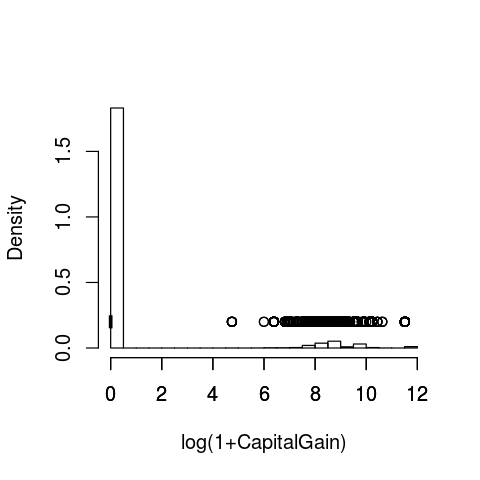

In [2]:
# dimensions des graphiques
options(repr.plot.width=4, repr.plot.height=4)
hist(dataBase[,"LcapitalGain"],probability=T, main="",xlab="log(1+CapitalGain)")
boxplot(dataBase[,"LcapitalGain"], horizontal=TRUE,boxwex=.2,  outline=TRUE,  
        frame=F, col = "lightgrey", add = TRUE,at=0.2)

Nécessité de transformer certaines variables avant de contruire des modèles linéaires puis mise en évidence de fortes redondances dans certaines variables.

In [3]:
table(dataBase$relationship,dataBase$sex)   

                
                 Female  Male
  Husband             1 18659
  Not-in-family    5404  6274
  Other-relative    599   721
  Own-child        2707  3477
  Unmarried        3649  1133
  Wife             2090     1

In [4]:
table(dataBase$education,dataBase$educNum)  

             
                  1     2     3     4     5     6     7     8     9    10    11
  Associates      0     0     0     0     0     0     0     0     0     0  1959
  Bachelors       0     0     0     0     0     0     0     0     0     0     0
  Doctorate       0     0     0     0     0     0     0     0     0     0     0
  Dropout        72   222   446   819   644  1073  1387   519     0     0     0
  HS-grad         0     0     0     0     0     0     0     0 14766     0     0
  HS-Graduate     0     0     0     0     0     0     0     0     0  9892     0
  Masters         0     0     0     0     0     0     0     0     0     0     0
  Prof-School     0     0     0     0     0     0     0     0     0     0     0
             
                 12    13    14    15    16
  Associates   1507     0     0     0     0
  Bachelors       0  7569     0     0     0
  Doctorate       0     0     0     0   544
  Dropout         0     0     0     0     0
  HS-grad         0     0     0 

In [5]:
table(dataBase$mariStat,dataBase$relationship)

               
                Husband Not-in-family Other-relative Own-child Unmarried  Wife
  Married         18660            19            184       125         0  2091
  Never-Married       0          6667            793      5423      1217     0
  Not-Married         0          4305            284       616      3054     0
  Widowed             0           687             59        20       511     0

In [6]:
table(dataBase$origEthn,dataBase$nativCountry)

             
              British-Commonwealth China Euro_1 Euro_2 Latin-America Other
  Amer-Indian                    0     1      1      2            12     0
  Asian                        125   185      4    101            13    61
  Black                         11     0     10      0           230     8
  Other                         12     0      2      1           125    11
  White                        333    10    313    229          1157   198
             
              SE-Asia South-America United-States
  Amer-Indian       1             1           410
  Asian           416             0           397
  Black             4             2          3929
  Other             0            31           166
  White            20           278         35905

Quelques mosaicplots importants montrant le liens des variables sensibles avec la cible (seuil de revenu).

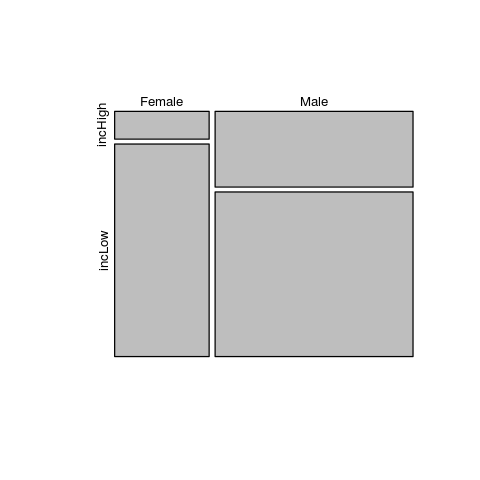

In [7]:
mosaicplot(table(dataBase[,"sex"],dataBase[,"income"]),main="")

**Q** Commentaire sur le biais présent dans la base.

On observe un biais au niveau de la base d'apprentissage. En effet les deux populations observées (femmes et hommes) présentent une grande différence de salaire (au niveau de la variable binaire income). 
Cette différence va avoir tendance à reproduire le biais structurel présent dans la société au niveau des salaires (bien qu'on ne connaisse pas sa valeur précise), voire le renforcer.

Il est aussi important de noter que, disposant de moins de données pour calculer les proportions de femmes ayant des hauts salaires et des bas salaires, l'erreur sur les données des femmes est plus grande que celle sur les données des hommes.


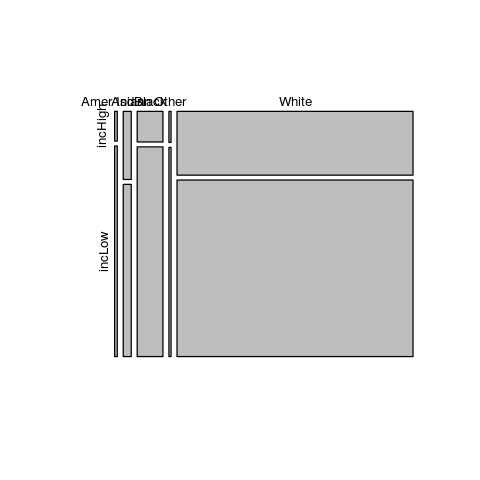

In [8]:
mosaicplot(table(dataBase[,"origEthn"],dataBase[,"income"]),main="")

Quelques modifications sont apportées de la base. Certaines variables en versions quantitatives et qualitatives comme le nombre d'heures par semaine, l'âge ou le niveau d'éducation sont conservées. Des variables sont supprimées afin de ne garder qu'une seule présence d'une information sensible: genre et origine ethnique.
- Suppression de la variable 3 `fnlwgt` qui n'a guère de signification.
- Création d'une variable binaire `Child`: présence ou non d'enfants
- Suppression de la variable 8 `relationship` redondante avec le genre et le statut marital,
- Suppression de la variable 14 `nativCountry` redondante avec l'origine ethnique.
- La variable 9 `originEthn` est simplifiée à 2 classes: CaucYes *vs.* CaucNo

In [9]:
dataBase[,"Child"]=as.factor(ifelse(dataBase$relationship=='Own-child',"ChildYes","ChildNo"))
dataBase[,"origEthn"]=as.factor(ifelse(dataBase$origEthn %in% c('Amer-Indian','Asian','Black','Other'),"CaucNo","CaucYes"))

datBas=dataBase[,-c(3,8,14)]

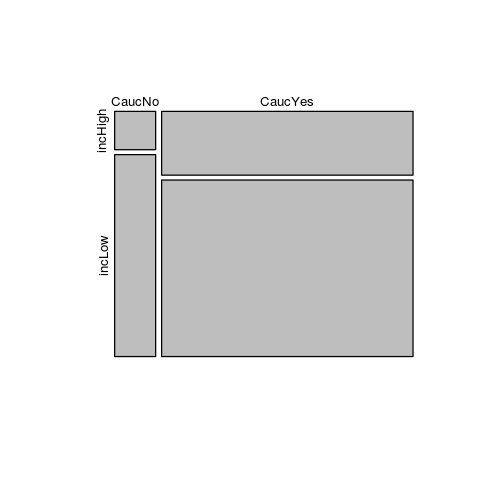

In [10]:
mosaicplot(table(dataBase[,"origEthn"],dataBase[,"income"]),main="")

**Q** Commentaire sur le biais présent dans la base.

On observe un biais au niveau de la base d'apprentissage. En effet les deux populations observées (caucasiens et non caucasiens) présentent une grande différence de salaire (au niveau de la variable binaire income). Ce biais semble toutefois moins important que celui entre femmes et hommes. 
Cette différence va avoir tendance à reproduire le biais structurel présent dans la société au niveau des salaires (bien qu'on ne connaisse pas sa valeur précise), voire le renforcer.

Il est aussi important de noter que, disposant de moins de données pour calculer les proportions de non caucasiens ayant des hauts salaires et des bas salaires, l'erreur sur les données des non caucasiens est plus grande que celle sur les données des caucasiens. Cette différence de répartition de l'échantillon est encore plus forte qu'entre les hommes et les femmes, ce qui va induire une différence de précision d'autant plus élevée.

In [11]:
summary(datBas)

      age                workClass           education        educNum     
 Min.   :18.00   Federal-Govt : 1390   HS-grad    :14766   Min.   : 1.00  
 1st Qu.:28.00   Not-Working  :   21   HS-Graduate: 9892   1st Qu.: 9.00  
 Median :37.00   Other-Govt   : 5023   Bachelors  : 7569   Median :10.00  
 Mean   :38.79   Private      :32856   Dropout    : 5182   Mean   :10.16  
 3rd Qu.:47.00   Self-Employed: 5425   Associates : 3466   3rd Qu.:13.00  
 Max.   :90.00                         Masters    : 2512   Max.   :16.00  
                                       (Other)    : 1328                  
          mariStat              occup          origEthn         sex       
 Married      :21079   Admin       : 5501   CaucNo : 6272   Female:14450  
 Never-Married:14100   Blue-Collar :14732   CaucYes:38443   Male  :30265  
 Not-Married  : 8259   Other-occups: 2391                                 
 Widowed      : 1277   Professional: 5992                                 
                       Sa

### 2.3  [Analyse factorielle multiple des correspondances](http://wikistat.fr/pdf/st-m-explo-afcm.pdf)
Cette méthode permet d'avoir une vue d'ensemble de la structure des liaisons entre les variables qualitatives prises 2 à 2. 

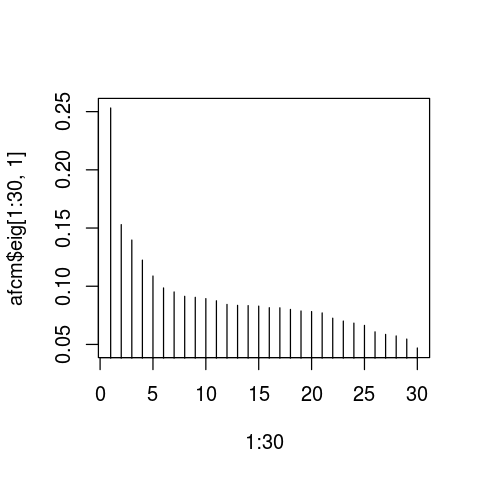

In [12]:
library(FactoMineR)
dataq=datBas[,c(2,3,5:10,12,15:17)]
afcm=MCA(dataq,graph=FALSE)
plot(1:30,afcm$eig[1:30,1],type="h")

Il pourrait être utile de considérer 3 ou 4 axes mais seuls deux sont utilisés dans cette approche élémentaire.

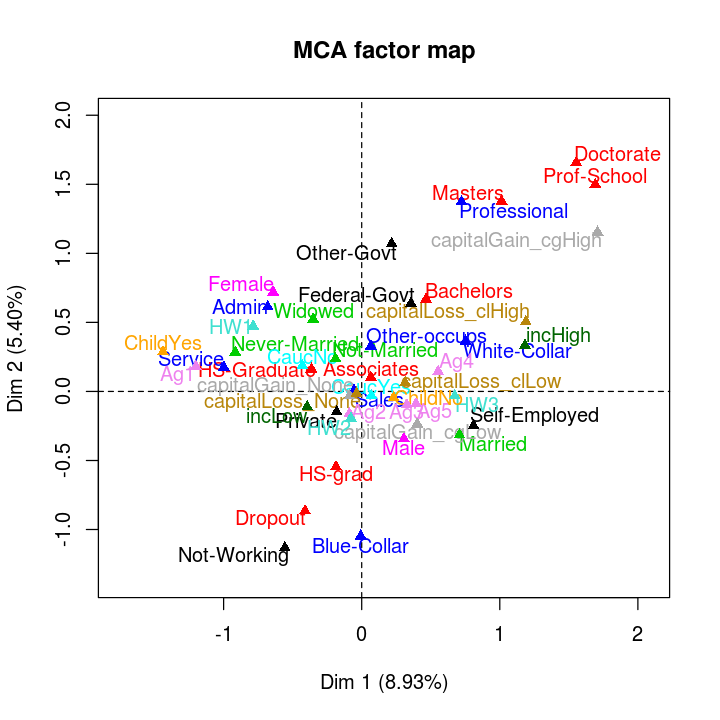

In [13]:
options(repr.plot.width=6, repr.plot.height=6)
plot.MCA(afcm,invisible=c("ind"),habillage="quali")

Remarquer la très forte et attendue liaison entre niveau d'éducation et activité selon un axe de dispersion suivant la première bissectrice lui même en relation avec les modalités haut et bas revenus alors que le genre, en première approximation, semble orthogonal à cet axe mais en relation avec le type d'activité et le nombre d'heures de travail par semaine.

Ce graphique laisse penser que le lien entre genre et niveau de revenu ne serait pas dû à une sous qualification des femmes mais à une moindre activité (travail partiel) ou à des types d'emplois moins rémunérés.

Cette représentation est complétée en projetant les individus colorés selon la variable revenu. De façon triviale, les hauts revenus se concentrent du côté des niveaux d'éducation les plus élevés.

*En résumé*: un lien direct entre revenu et niveau d'éducation, pas nécessairement de lien entre genre et niveau d'éducation mais un "frein" au revenu lié au type de travail ou d'occupation : administratif, service... et à de possibles temps partiels.

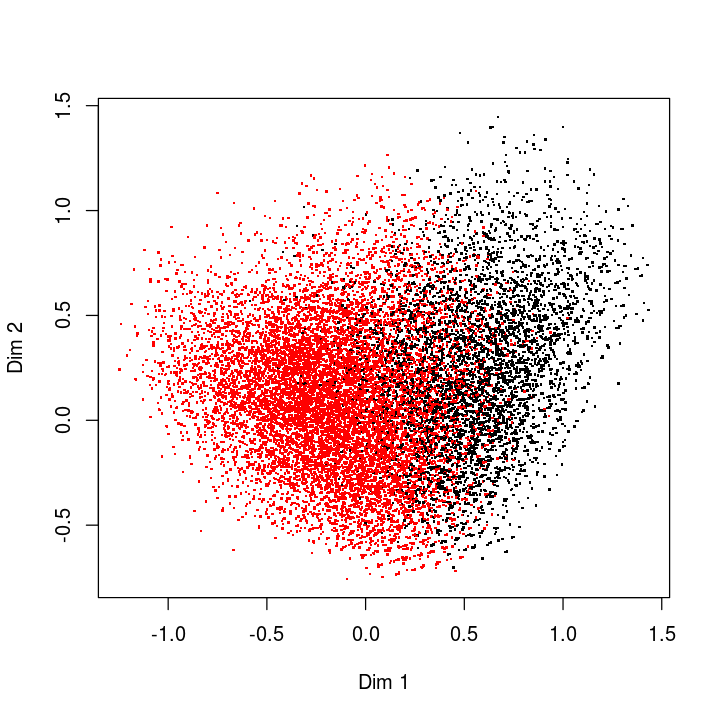

In [14]:
plot(afcm$ind$coord,type="p",pch=".",cex=2,col=as.integer(dataBase$income))

## 3 Modèles de prévision du seuil de revenu
Une comparaison détaillée de la plupart des modèles et algorithmes de prévision du seuil de revenu en fonction des différentes variables met en évidence des résultats un peu meilleurs obtenus par l'algorithme de *gradient boosting*. Néanmoins, on peut se limiter ici à un modèle de régression logisitique très compétitif et interprétable. Un arbe de décision seul donne également une précision similaire mais beaucoup trop complexe (profondeur) pour être interprétable. 

### 3.1 Echantillons
Les données sont préalablement séparées en deux échantillons apprentissage et test.

In [15]:
set.seed(111) # initialisation du générateur
# Extraction des échantillons
test.ratio=.2   # part de l'échantillon test
npop=nrow(datBas) # nombre de lignes dans les données
nvar=ncol(datBas) # nombre de colonnes
# taille de l'échantillon test
ntest=ceiling(npop*test.ratio) 
# indices de l'échantillon test
testi=sample(1:npop,ntest)
# indices de l'échantillon d'apprentissage
appri=setdiff(1:npop,testi) 

In [16]:
# construction de l'échantillon d'apprentissage
datApp=datBas[appri,]
# construction de l'échantillon test 
daTest=datBas[testi,]

### 3.2 Prévision par régression logistique
Comme la plupart des coefficients sont significatifs au sens d'un test de Fisher et par souci de simplicité, il n'est pas fait de sélection de modèle ni non plus tenté un modèle avec des interactions. 

In [17]:
# estimation du modèle complet
log.lm=glm(income~.,data=datApp,family=binomial)
# significativité des paramètres
anova(log.lm,test="Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,35771,40203.12,NA
age,1,1900.36292,35770,38302.75,0.000000e+00
workClass,4,218.21840,35766,38084.54,4.532105e-46
education,7,4196.09766,35759,33888.44,0.000000e+00
educNum,1,30.43103,35758,33858.01,3.459492e-08
mariStat,3,6238.45525,35755,27619.55,0.000000e+00
occup,6,849.67411,35749,26769.88,2.838387e-180
origEthn,1,14.33522,35748,26755.54,1.529757e-04
sex,1,43.11366,35747,26712.43,5.165050e-11
capitalGain,2,2140.71348,35745,24571.71,0.000000e+00


In [18]:
# Prévision
pred.log=predict(log.lm,newdata=daTest,type="response")
# Matrice de confusion pour la prévision du 
# dépassement de seuil
confMat=table(pred.log<0.5,daTest$income)
confMat

       
        incHigh incLow
  FALSE     877   6228
  TRUE     1397    441

In [19]:
(confMat[1,1]+confMat[2,2])/sum(confMat)

[1] 0.1473778

Les résultats sont très similaires à ceux obtenus par d'autres algorithmes comme les forêts aléatoires.

### 3.3 Modèle de régression sans la variable genre

In [20]:
# estimation du modèle complet
log_g.lm=glm(income~.,data=datApp[,-8],family=binomial)
# significativité des paramètres
anova(log_g.lm,test="Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,35771,40203.12,NA
age,1,1900.36292,35770,38302.75,0.000000e+00
workClass,4,218.21840,35766,38084.54,4.532105e-46
education,7,4196.09766,35759,33888.44,0.000000e+00
educNum,1,30.43103,35758,33858.01,3.459492e-08
mariStat,3,6238.45525,35755,27619.55,0.000000e+00
occup,6,849.67411,35749,26769.88,2.838387e-180
origEthn,1,14.33522,35748,26755.54,1.529757e-04
capitalGain,2,2154.37072,35746,24601.17,0.000000e+00
capitalLoss,2,353.34994,35744,24247.82,1.866535e-77


In [21]:
# Prévision
pred_g.log=predict(log_g.lm,newdata=daTest[,-8],type="response")
# Matrice de confusion pour la prévision du 
# dépassement de seuil
confMat=table(pred_g.log<0.5,daTest$income)
confMat

       
        incHigh incLow
  FALSE     876   6229
  TRUE     1398    440

In [22]:
(confMat[1,1]+confMat[2,2])/sum(confMat)

[1] 0.1471542

La qualité de prévision est sensiblement la même.
### 3.4 Régression logistique sans l'origine

In [23]:
# estimation du modèle complet
log_o.lm=glm(income~.,data=datApp[,-7],family=binomial)
# Prévision
pred_o.log=predict(log_o.lm,newdata=daTest[,-7],type="response")
# Matrice de confusion pour la prévision du 
# dépassement de seuil
confMat=table(pred_o.log<0.5,daTest$income)
confMat; (confMat[1,1]+confMat[2,2])/sum(confMat)

       
        incHigh incLow
  FALSE     879   6228
  TRUE     1395    441

[1] 0.1476015

Même remarque.

In [24]:
(confMat[1,2]+confMat[2,1])/sum(confMat)

[1] 0.8523985

## 4 Estimation de l'effet disproportionné
La notion d'effet dispropostionné est apparu aux USA en 1971 pour détecter des situations discriminatoires à l'embauche. Cette quantitaté est définie par le rapport:$\frac{P(X=1|S=0)}{P(X=1|S=1)}$ de deux probabilités. La probabilité de bénéficier d'une situation ou décision favorable (revenu élevé) pour une personne du groupe protégé (femme, origine non caucasienne) sur la même probabilité pour une personne de l'autre groupe (homme, origine caucasienne).
### 4.1 Fonction *disparate*
Besse P. ,del Barrio E., Gordaliza P., Loubes J.-M. (2018-a). Confidence Intervals for testing Disparate Impact in Fair Learning, [arXiv](https://arxiv.org/abs/1807.06362).

La  fonction ci-dessous a trois arguments pour estimer le disparate impact par intervalle de confiance.
- une matrice $X$ de valeurs binaires $(0,1)$ dont la dernière colonne contient la décision ou cible à analyser;
- l'indice $S$ de la variable de $X$ considérée comme sensible; 
- le risque de l'intervalle de confiance, par défaut 5%
Elle renvoie un intervalle de confiance estimant la valeur $T_n$ du *disparate impact*.

In [25]:
source("disparate.R")
disparate

function (X, S, alpha = 0.05) 
{
    if (S > ncol(X)) 
        stop(paste("L'argument S doit être compris entre 1 et ", 
            ncol(X) - 1))
    n <- nrow(X)
    pi_1 <- sum(X[, S])/n
    pi_0 <- 1 - pi_1
    p_1 <- sum(X[, S] * X[, ncol(X)])/n
    p_0 <- sum((1 - X[, S]) * X[, ncol(X)])/n
    Tn <- p_0 * pi_1/(p_1 * pi_0)
    grad <- grad_h(c(p_0, p_1, pi_0, pi_1))
    Cov_4 <- diag(rep(0, 4)) + cbind(c(0, -p_0 * p_1, pi_1 * 
        p_0, -pi_1 * p_0), c(0, 0, -pi_0 * p_1, pi_0 * p_1), 
        c(0, 0, 0, -pi_0 * pi_1), c(0, 0, 0, 0))
    Cov_4 <- Cov_4 + t(Cov_4) + diag(c(p_0 * (1 - p_0), p_1 * 
        (1 - p_1), pi_0 * pi_1, pi_0 * pi_1))
    sigma <- sqrt((grad %*% Cov_4) %*% t(t(grad)))
    lower_lim <- Tn - (sigma * qnorm(1 - alpha/2, mean = 0, sd = 1))/sqrt(n)
    upper_lim <- Tn + (sigma * qnorm(1 - alpha/2, mean = 0, sd = 1))/sqrt(n)
    return(c(lower_lim, Tn, upper_lim))
}

### 4.2 *Disparate impact* de la base d'apprentissage
Calculé sur les données initiales, le *disparate impact* met en évidence un biais social fort. Les variables sensibles sont le genre puis l'origine ethnique

In [26]:
# Variable genre rendue entière: 0, 1
s1= as.integer(datBas[,8])-1
# variable origine ethnique rendue entière 0, 1
s2= as.integer(datBas[,7])-1
# Variable cible ou décision (seuil de revenu) également entière: 0, 1
Y=as.numeric(datBas$income) 
Y[Y==2]=0
coded_data=data.frame(s1,s2,Y)

#### Ségrégation vis à vis du genre

Le $DI$ est simplement estimé à partir de la table de contingence par le rapport:
$\frac{n_{21}}{(n_{11}+n_{21})}/\frac{n_{22}}{(n_{12}+n_{22})}$ tandis que le risque de cette estimation est contrôlé par un intervalle de confiance à 95%.

In [27]:
disparate(coded_data,1)
DI_reel1 = disparate(coded_data,1)[2]
print(DI_reel1)

[1] 0.3489865 0.3666135 0.3842406

[1] 0.3666135


#### Ségrégation vis à vis de l'origine: caucasienne *vs.* autre. 

In [28]:
disparate(coded_data,2)
DI_reel2 = disparate(coded_data,2)[2]
print(DI_reel2)

[1] 0.5657520 0.6013363 0.6369206

[1] 0.6013363


Discrimination nettement plus importante selon le genre que selon l'origine ethnique.

### 4.3 *Disparate impact* des prévisions par régression logistique
La valeur seuil de la probabilité de dépassement du seuil de revenu est fixée à 0.5.

In [29]:
Y=as.numeric(pred.log<0.5)
Y[Y==2]=0
coded_data=data.frame(s1[testi],s2[testi],Y)

#### Avec régression logistique et par genre
La prévision reproduit et même renforce statistiquement le biais social pour le genre.

In [30]:
disparate(coded_data,1)

[1] 0.1863886 0.2197458 0.2531030

#### Avec régression logistique et par origine
Le renforcement du biais selon l'origine n'est pas statistiquement significatif.

In [31]:
disparate(coded_data,2)

[1] 0.3756060 0.4529523 0.5302986

### 4.4 *Disparate impact* des prévisions sans la variable sensible
Le genre ou l'origine ethnique impacte le type d'activité et en conséquence le revenu. Aussi, supprimer la variable sensible du modèle ne suffit évidemment pas à réduire le biais discirminatoire.
#### Avec la régression et par genre

In [32]:
Y=as.numeric(pred_g.log<0.5)
Y[Y==2]=0
coded_data=data.frame(s1[testi],s2[testi],Y)
disparate(coded_data,1)

[1] 0.1916470 0.2254873 0.2593276

#### Avec la régression et par origine

In [33]:
Y=as.numeric(pred_o.log<0.5)
Y[Y==2]=0
coded_data=data.frame(s1[testi],s2[testi],Y)
disparate(coded_data,2)

[1] 0.4008414 0.4806431 0.5604448

La réduction du *disparate impact* obtenue en supprimant la variable sensible n'est pas statistiquement significative de même que les erreurs de prévisions restent stables. Le déterminisme social est plus fort que la présence de la variable sensible: *une femme ou une personne non caucasienne travaille moins ou de façon moins qualifiée quelque soit son niveau d'éducation*. 

### 4.5 Faux positifs et négatifs selon la variable sensible (cf. Propublica)
Une autre source de discrimination, mise en évidence par le site [Propublica](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) à propos du score de récidive,  concerne une inversion du déséquilibre de la matrice de confusion selon la variable sensible; comparer les nombre de faux positifs ou faux négatifs selon le genre ou l'origine.
#### Par genre

In [34]:
table(pred.log<0.5,daTest$income,daTest$sex)

, ,  = Female

       
        incHigh incLow
  FALSE     166   2486
  TRUE      139     30

, ,  = Male

       
        incHigh incLow
  FALSE     711   3742
  TRUE     1258    411


Alors que, pour les hommes, le taux de faux positifs est assez similaire au taux de faux négatifs, pour les femmes, il est sensiblement plus fréquent de se tromper en prévoyant un revenu bas alors qu'il est élevé.
#### Par origine

In [35]:
table(pred_o.log>0.5,daTest$income,daTest$origEthn)

, ,  = CaucNo

       
        incHigh incLow
  FALSE     100     33
  TRUE       76   1041

, ,  = CaucYes

       
        incHigh incLow
  FALSE    1295    408
  TRUE      803   5187


Pas facile à interpréter...

## 5 Sensibilité au *testing* et correction
### 5.1 Introduction

#### [Historique](https://fr.wikipedia.org/wiki/Test_de_discrimination)
depuis 1939 en France pour les boîtes de nuit.

#### [Validité juridique](https://www.juritravail.com/discrimination-physique/embauche/ph-alternative-A-1.html) 
du *testing* accepté comme preuve de discrimiantion depuis 2016.

#### Approches sociologiques 
Le test de discrimination ou *testing* automatique est pratiquée en France de façon systématique pour des études sociologiques par l'[Observatoire des discriminations](http://www.observatoiredesdiscriminations.fr/testing), le laboratoire TEPP: [L'Horty et al. (2017)](http://www.tepp.eu/doc/users/268/bib/banque-et-assurance_9025.pdf), ou pilotée par la [DARES](http://dares.travail-emploi.gouv.fr/dares-etudes-et-statistiques/etudes-et-syntheses/dares-analyses-dares-indicateurs-dares-resultats/testing) du ministère du travail en lien avec l'association [ISM Corum](http://www.ismcorum.org/).... Certains entreprises demandent d'ailleurs à ISM Corum de [tester leur mode de recrutement](http://www.ismcorum.org/le-testing-d-entreprise-%E2%80%93-temoignages-d-adecco-casino-lvmh-michael-page-M22-R22-A443.html). Il serait sans doute intéressant de disposer des données brutes sur l'enquête citée mais seules les [tableaux agrégés](http://dares.travail-emploi.gouv.fr/IMG/xls/donnees_a_telecharger-_dares_analyses_no076.xls) sont accessibles. 

*Remarques*: des groupes à contacter?
- l'observatoire des discriminations propose un [audit qualité](http://www.observatoiredesdiscriminations.fr/diagnostics-qualite) des procédures de recrutement. 
- [Novethic](https://www.novethic.fr/lexique/detail/testing.html), filliale de la caisse des dépôts et consignation, donnent des formations pour des entreprises "éthiques".

#### *Testing* et estimation du biais
Dans un autre ordre d'idée, [Galhotra et al. (2017)](https://arxiv.org/abs/1709.03221) définissent le biais d'une décision en incluant une notion de causalité. Le logiciel afférent ([Themis](https://github.com/LASER-UMASS/Themis)) opère un *testing* de logiciels ou décisions automatiques dans le but d'évaluer les proportions d'individus virtuels discriminés permettant d'estimer ce critère de biais. Les individus virtuels sont générés par permutation aléatoire des valeurs prises pour les modalités des variables explicatives nécessairement qualitatives ou découpées en classe.

#### *Testing* rudimentaire
Analysons la robustesse des deux modèles à une opération de *testing* rudimentaire: un nouvel échantillon test est construit en *échangeant les deux modalités de la variables sensible*. La variable cible (seuil de revenu) est ensuite reprédite par le modèle initial donné. 

*Question*: Des prévisions sont elles modifiés et pour quels individus?

Existe-t-il des personnes pour lesquelles le seul changement de genre ou d'origine a pour effet de changer la prévision du seuil de revenu `income`? 

C'est en effet parmi ces personnes de l'échantillon test que se trouvent celles discriminées par la décision apprise et donc susceptibles d'une action en justice lorsque la décision algorihtmique (*e.g.* accès au crédit, à l'assurance, à l'amploi...) impacte cette personne. Cette discrimination individuelle peut en effet peut en effet être mise en évidence contrairement à la discrimination vis à vis d'un groupe dont il n'existe pas de définition ou de caractérisation. 

Evidemment, comme pour l'estimation du *disparate impact*, il est nécessaire de disposer de la variable sensible (genre ou origine) pour pouvoir opérer du *testing*.


### 5.2 Personnes discriminées selon leur genre

Le comportement des deux prédicteurs est différent mais assez logiquement. Le prédicteur linéaire (logistique) est monotone vis à vis du changement de genre ou d'origine tandis que le modèle non linéaire (rf) produit des résultats assez erratiques.

#### Modification de l'échantillon et prévisions.

In [36]:
daTest2=daTest
daTest2$sex=as.factor(ifelse(daTest$sex=="Male","Female","Male"))
# Prévision du "nouvel" échantillon test
pred2.log=predict(log.lm,daTest2,type="response")

#### Dans le cas de la régression logistique
La situation est tranchée.

In [37]:
table(pred.log<0.5,pred2.log<0.5)

       
        FALSE TRUE
  FALSE  7098    7
  TRUE     64 1774

Même chose mais répartition par genre.

In [38]:
table(pred.log<0.5,pred2.log<0.5,daTest$sex)

, ,  = Female

       
        FALSE TRUE
  FALSE  2645    7
  TRUE      0  169

, ,  = Male

       
        FALSE TRUE
  FALSE  4453    0
  TRUE     64 1605


**N.B.** Il n'y a cette fois plus que 94 personnes dont la prévision de revenu change lorsqu'elles changent de genre. Et le changement est dans le sens attendu.
- 10 femmes qui passent d'une prévision de revenu faible à une prévision de revenu élevé
- 84 hommes qui prennnent le chemin inverse (discrimination initiale positive) lorsqu'ils deviennent des femmes.

In [39]:
which(pred.log>0.5&pred2.log<0.5&daTest$sex=="Female")  # 10 femmes dans ce cas

17410 39536 13116  1498 17647 35492 15290 
 1593  2330  4896  7242  7254  7578  8192

In [40]:
which(pred.log>0.5&pred2.log<0.5&daTest$sex=="Male") # 0 homme dans ce cas

named integer(0)

### 5.3 Personnes discriminées selon leur origine
Mêmes calculs vis-à-vis de la variable sensible origine.
#### Modification de l'échantillon et prévisions

In [41]:
daTest3=daTest
daTest3$origEthn=as.factor(ifelse(daTest$origEthn=="CaucYes","CaucNo","CaucYes"))
# Prévision du "nouvel" échantillon test
pred3.log=predict(log.lm,newdata=daTest3,type="response")

#### Dans le cas de la régression logisitique
Comme pour la discrimination selon le genre, la détection de personnes discriminées selon leur origine est nette. Les prévisions de seuil de revenu de 160 personnes sont affectées par le changement d'origine.
- 12 sont discriminées par leur origine
- 148 bénéficient d'une discrimination positive

In [42]:
table(pred.log<0.5,pred3.log<0.5)

       
        FALSE TRUE
  FALSE  7098    7
  TRUE    184 1654

In [43]:
table(pred.log<0.5,pred3.log<0.5,daTest$origEthn)

, ,  = CaucNo

       
        FALSE TRUE
  FALSE  1117    7
  TRUE      0  126

, ,  = CaucYes

       
        FALSE TRUE
  FALSE  5981    0
  TRUE    184 1528


In [44]:
table(pred.log<0.5,pred2.log<0.5,daTest$sex,daTest$income)

, ,  = Female,  = incHigh

       
        FALSE TRUE
  FALSE   163    3
  TRUE      0  139

, ,  = Male,  = incHigh

       
        FALSE TRUE
  FALSE   711    0
  TRUE     34 1224

, ,  = Female,  = incLow

       
        FALSE TRUE
  FALSE  2482    4
  TRUE      0   30

, ,  = Male,  = incLow

       
        FALSE TRUE
  FALSE  3742    0
  TRUE     30  381


Réponse: de façon homogène. M

#### Variable sensible origine

In [45]:
table(pred.log<0.5,pred2.log<0.5,daTest$origEthn,daTest$income)

, ,  = CaucNo,  = incHigh

       
        FALSE TRUE
  FALSE    79    0
  TRUE      4   93

, ,  = CaucYes,  = incHigh

       
        FALSE TRUE
  FALSE   795    3
  TRUE     30 1270

, ,  = CaucNo,  = incLow

       
        FALSE TRUE
  FALSE  1045    0
  TRUE      3   26

, ,  = CaucYes,  = incLow

       
        FALSE TRUE
  FALSE  5179    4
  TRUE     27  385


#### *Local fair prediction error* 
Pour la régession logistique, fixer comme probablité prédite le minimium des deux probablités obtenues en échangeant les modalités de la variable sensible. De façon générale, quelques soit le prédicteur, choisir la situaiton plus favorable pour la personne, quelque soit le genre (resp. l'origine) observé. La discimination individuelle repérable par *testing* est neutralisée et l'influence sur le taux d'erreur quasi négligeable; n'induire éventuellement que de la *discrimination positive* pour le groupe sensible si cela améliore le taux d'erreur global.

*Régression logistique et genre*

In [46]:
predict.fairRegLog=ifelse(pred.log<pred2.log,pred.log,pred2.log)
confMat=table(predict.fairRegLog<0.5,daTest$income)
confMat;(confMat[1,1]+confMat[2,2])/sum(confMat)

       
        incHigh incLow
  FALSE     874   6224
  TRUE     1400    445

[1] 0.1474897

*Régression logistique et origine*

In [47]:
predict.fairRegLog=ifelse(pred.log<pred3.log,pred.log,pred3.log)
confMat=table(predict.fairRegLog<0.5,daTest$income)
confMat;(confMat[1,1]+confMat[2,2])/sum(confMat)

       
        incHigh incLow
  FALSE     874   6224
  TRUE     1400    445

[1] 0.1474897

Pour la régresison logistique, la correction qui rend la décision localement loyale c'est-à-dire en supprimant tout discrimination individuelle n'a qu'un impact très marginal sur l'erreur de prévision. 

Qu'en est-il de la correction de l'effet disproportionné?

## 6 Correction du biais par modification des seuils de décision
L'idée consiste à simplement abaisser le seuil (0.5 par défaut) de décision de la régression logistique pour rendre celle-ci plus favorable au groupe sensible et donc d'introduire une forme de discrimination positive afin de corriger le biais.

**Questions**:
Quelle valeur apporter pour réduire significativement le biais afin que 
1. la régression logistique ne fasse que reproduire celui des données.
2. la borne supérieur de l'IC du DI soit plus grande que 0/8

Tracer deux courbes motrant l'évolution du DI (de son intervalle de confiance) et celle de l'erreur de prévision en fonction de la valeur de ce seuil.

In [48]:
testih = which(daTest$sex=="Male")
testif = which(daTest$sex=="Female")
daTestf=daTest[testif,]
daTesth=daTest[testih,]

log.lm=glm(income~.,data=datApp,family=binomial)
# Prévision
pred.logTest=predict(log.lm,newdata=daTest,type="response")

# Prévision
#pred.logh=predict(log.lm,newdata=daTest,type="response")


[1] 0.09324983


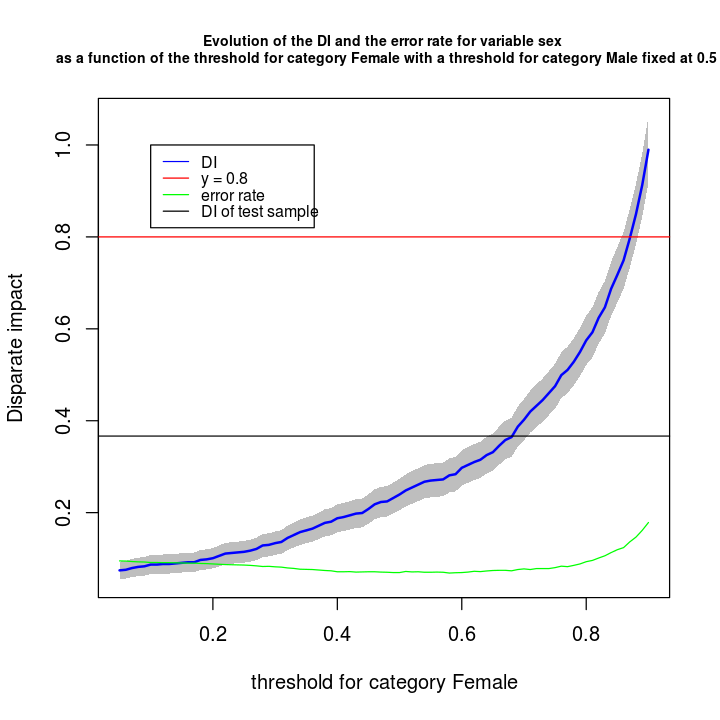

In [60]:
seuil = seq(0.05,0.9,by=10e-3)

testseuil = function(seuil1, seuil2, daTest1, daTest2,testi1, testi2, indice, pred.log){

      
    Y1=as.numeric(pred.log[testi1]<seuil1)
    Y2=as.numeric(pred.log[testi2]<seuil2)
    Y1[Y1==2]=0
    Y2[Y2==2]=0
    
   
    s11 = as.integer(daTest1[,8])-1
    s12 = as.integer(daTest1[,7])-1
    s21 = as.integer(daTest2[,8])-1
    s22 = as.integer(daTest2[,7])-1
    
    coded_data1=data.frame("s1"=s11,"s2"=s12,"Y"=Y1)
    coded_data2=data.frame("s1"=s21,"s2"=s22,"Y"=Y2)
    coded_data <- rbind(coded_data1, coded_data2)
    
    di = disparate(coded_data,indice)
    
    confMat1=table(pred.log[testi1]<seuil1,daTest1$income)
    erreur1 = (confMat1[1,1]+confMat1[2,2])/sum(confMat1)
    confMat2=table(pred.log[testi2]<seuil2,daTest2$income)
    erreur2 = (confMat2[1,1]+confMat2[2,2])/sum(confMat2)
    
    return (c(di[1],di[2],di[3], erreur1, erreur2))
}

testDI = list()
erreur = list()
for (k in seuil){
    ts = testseuil(k, 0.5, daTestf, daTesth,testif, testih, 1, pred.logTest1)
    testDI = rbind(testDI,ts[c(1,2,3)])
    erreur = rbind(erreur, ts[4])
}



moyen = as.numeric(testDI[,2])
sup = as.numeric(testDI[,3])
inf = as.numeric(testDI[,1])
plot(NULL,NULL,xlim=c(min(seuil),max(seuil)),ylim=c(min(inf),max(sup)),
xlab="threshold for category Female",ylab="Disparate impact", main="Evolution of the DI and the error rate for variable sex \n as a function of the threshold for category Female with a threshold for category Male fixed at 0.5", cex.main=0.7)



## Intervalle de confiance [0.025;0.975]
polygon(x=c(seuil,rev(seuil)),y=c(inf,rev(sup)),col="grey",border=NA)
lines(seuil,moyen,lwd=2,col="blue")
abline(0.8, 0, col='red')
lines(seuil, erreur, col='green')
abline(DI_reel1, 0, col='black')
legend(0.1,1,legend=c("DI", "y = 0.8", "error rate","DI of test sample"),
       col=c("blue", "red", "green","black"), lty=1, cex=0.8)
confMat1=table(pred.logTest1[testif]<0.8,daTestf$income)
print((confMat1[1,1]+confMat1[2,2])/sum(confMat1))

[1] 0.1188359


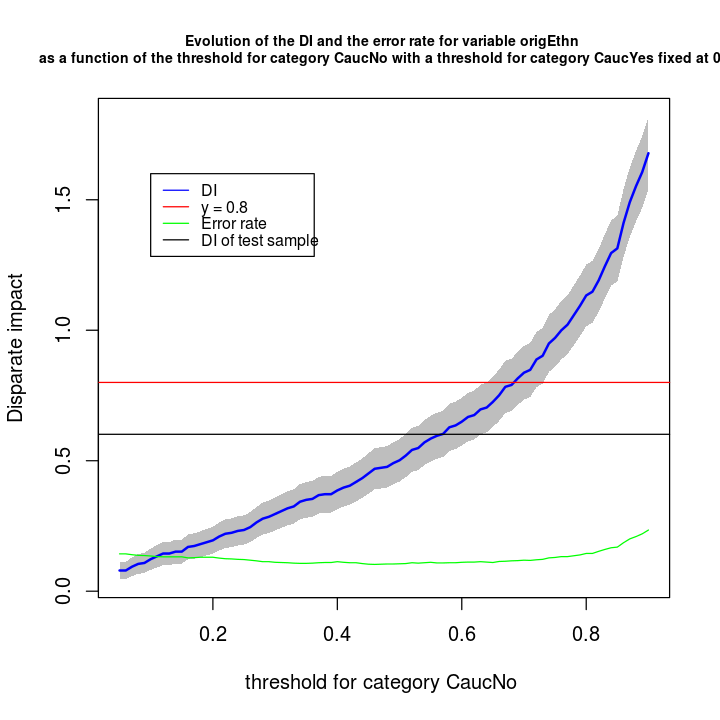

In [61]:
seuil = seq(0.05,0.9,by=10e-3)

testin = which(daTest$origEthn=="CaucNo")
testiy = which(daTest$origEthn=="CaucYes")
daTestn=daTest[testin,]
daTesty=daTest[testiy,]

# Prévision
#pred.logCau=predict(log.lm,newdata=daTest,type="response")

# Prévision
#pred.logy=predict(log.lm,newdata=daTesty,type="response")

testDI2 = list()
erreur2 = list()
for (k in seuil){
    ts = testseuil(k, 0.5, daTestn, daTesty, testin, testiy, 2, pred.logTest1)
    testDI2 = rbind(testDI2,ts[c(1,2,3)])
    erreur2 = rbind(erreur2, ts[4])
}


moyen = as.numeric(testDI2[,2])
sup = as.numeric(testDI2[,3])
inf = as.numeric(testDI2[,1])
plot(NULL,NULL,xlim=c(min(seuil),max(seuil)),ylim=c(min(inf),max(sup)),
xlab="threshold for category CaucNo ",ylab="Disparate impact", main="Evolution of the DI and the error rate for variable origEthn \n as a function of the threshold for category CaucNo with a threshold for category CaucYes fixed at 0.5",cex.main=0.7)

## Intervalle de confiance [0.025;0.975]
polygon(x=c(seuil,rev(seuil)),y=c(inf,rev(sup)),col="grey",border=NA)
lines(seuil,moyen,lwd=2,col="blue")
abline(0.8, 0, col='red')
lines(seuil, erreur2, col='green')
abline(DI_reel2, 0, col='black')
legend(0.1,1.6,legend=c("DI", "y = 0.8", "Error rate","DI of test sample"),
       col=c("blue", "red", "green","black"), lty=1, cex=0.8)
confMat1=table(pred.logTest1[testin]<0.7,daTestn$income)
print((confMat1[1,1]+confMat1[2,2])/sum(confMat1))

## Test de validation

In [51]:
test.ratio=.2 # part de l'échantillon test
valid.ratio=.2 # part de l'echantillon valid
npop=nrow(datBas) # nombre de lignes dans les données
nvar=ncol(datBas) # nombre de colonnes
# taille de l'échantillon test
ntest=ceiling(npop*test.ratio)
# taille de l'echantillon valid
nvalid=ceiling(npop*valid.ratio)
# indices de l'échantillon test
testi=sample(1:npop,ntest)
rest=setdiff(1:npop,testi) 
# indices de l'echantillon valid
validi = sample(rest,nvalid)
# indices de l'échantillon d'apprentissage
appri= setdiff(rest,validi)
# construction de l'échantillon d'apprentissage
datApp=datBas[appri,]
# construction de l'échantillon test 
daTest=datBas[testi,]
# construction de l'echantillon valid
daValid=datBas[validi,]

In [52]:
testih = which(daTest$sex=="Male")
testif = which(daTest$sex=="Female")
daTestf=daTest[testif,]
daTesth=daTest[testih,]
# Prévision
pred.logTest1=predict(log.lm,newdata=daTest,type="response")

In [55]:
validih = which(daValid$sex=="Male")
validif = which(daValid$sex=="Female")
daValidf=daValid[validif,]
daValidh=daValid[validih,]
# Prévision
pred.logValid=predict(log.lm,newdata=daValid,type="response")

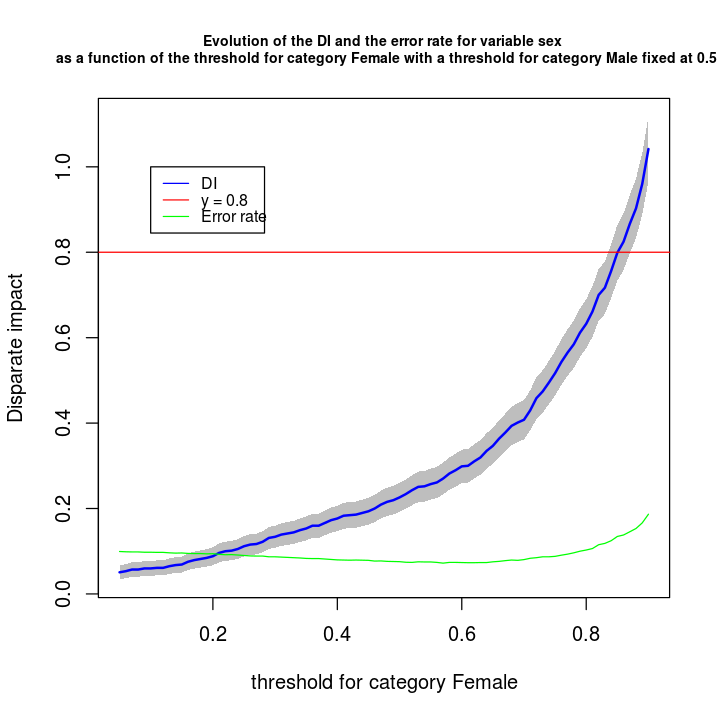

In [56]:
seuil = seq(0.05,0.9,by=10e-3)

testseuil = function(seuil1, seuil2, daTest1, daTest2,testi1, testi2, indice, pred.log){

      
    Y1=as.numeric(pred.log[testi1]<seuil1)
    Y2=as.numeric(pred.log[testi2]<seuil2)
    Y1[Y1==2]=0
    Y2[Y2==2]=0
    
   
    s11 = as.integer(daTest1[,8])-1
    s12 = as.integer(daTest1[,7])-1
    s21 = as.integer(daTest2[,8])-1
    s22 = as.integer(daTest2[,7])-1
    
    coded_data1=data.frame("s1"=s11,"s2"=s12,"Y"=Y1)
    coded_data2=data.frame("s1"=s21,"s2"=s22,"Y"=Y2)
    coded_data <- rbind(coded_data1, coded_data2)
    
    di = disparate(coded_data,indice)
    
    confMat1=table(pred.log[testi1]<seuil1,daTest1$income)
    erreur1 = (confMat1[1,1]+confMat1[2,2])/sum(confMat1)
    confMat2=table(pred.log[testi2]<seuil2,daTest2$income)
    erreur2 = (confMat2[1,1]+confMat2[2,2])/sum(confMat2)
    
    return (c(di[1],di[2],di[3], erreur1, erreur2))
}

testDI = list()
erreur = list()
for (k in seuil){
    ts = testseuil(k, 0.5, daValidf, daValidh,validif, validih, 1, pred.logValid)
    testDI = rbind(testDI,ts[c(1,2,3)])
    erreur = rbind(erreur, ts[4])
}



moyen = as.numeric(testDI[,2])
sup = as.numeric(testDI[,3])
inf = as.numeric(testDI[,1])
plot(NULL,NULL,xlim=c(min(seuil),max(seuil)),ylim=c(min(inf),max(sup)),
xlab="threshold for category Female",ylab="Disparate impact", main="Evolution of the DI and the error rate for variable sex \n as a function of the threshold for category Female with a threshold for category Male fixed at 0.5", cex.main=0.7)



## Intervalle de confiance [0.025;0.975]
polygon(x=c(seuil,rev(seuil)),y=c(inf,rev(sup)),col="grey",border=NA)
lines(seuil,moyen,lwd=2,col="blue")
abline(0.8, 0, col='red')
lines(seuil, erreur, col='green')
legend(0.1,1,legend=c("DI", "y = 0.8", "Error rate"),
       col=c("blue", "red", "green"), lty=1, cex=0.8)

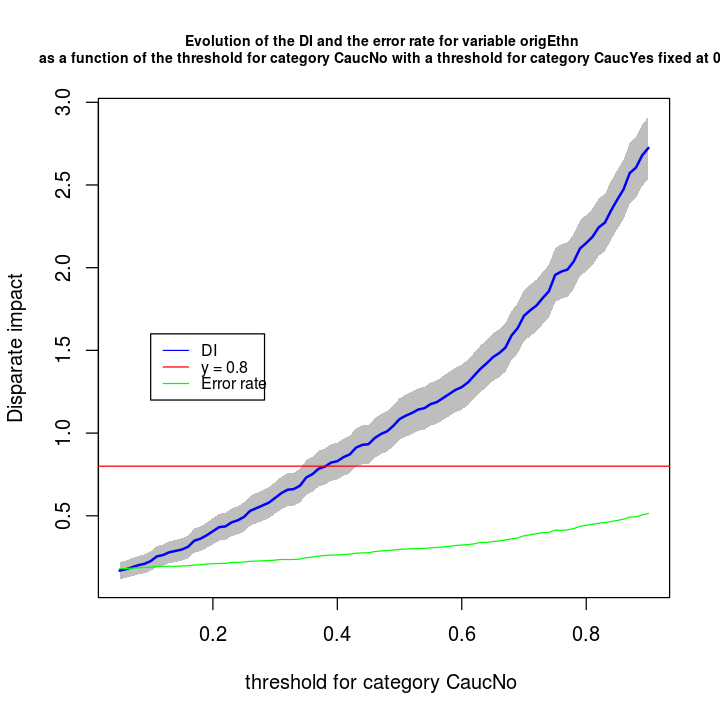

In [57]:
seuil = seq(0.05,0.9,by=10e-3)

testin = which(daTest$origEthn=="CaucNo")
testiy = which(daTest$origEthn=="CaucYes")
daTestn=daTest[testin,]
daTesty=daTest[testiy,]

# Prévision
#pred.logCau=predict(log.lm,newdata=daTest,type="response")

# Prévision
#pred.logy=predict(log.lm,newdata=daTesty,type="response")

testDI2 = list()
erreur2 = list()
for (k in seuil){
    ts = testseuil(k, 0.5, daTestn, daTesty, testin, testiy, 2,pred.logValid)
    testDI2 = rbind(testDI2,ts[c(1,2,3)])
    erreur2 = rbind(erreur2, ts[4])
}


moyen = as.numeric(testDI2[,2])
sup = as.numeric(testDI2[,3])
inf = as.numeric(testDI2[,1])
plot(NULL,NULL,xlim=c(min(seuil),max(seuil)),ylim=c(min(inf),max(sup)),
xlab="threshold for category CaucNo ",ylab="Disparate impact", main="Evolution of the DI and the error rate for variable origEthn \n as a function of the threshold for category CaucNo with a threshold for category CaucYes fixed at 0.5",cex.main=0.7)

## Intervalle de confiance [0.025;0.975]
polygon(x=c(seuil,rev(seuil)),y=c(inf,rev(sup)),col="grey",border=NA)
lines(seuil,moyen,lwd=2,col="blue")
abline(0.8, 0, col='red')
lines(seuil, erreur2, col='green')
legend(0.1,1.6,legend=c("DI", "y = 0.8", "Error rate"),
       col=c("blue", "red", "green"), lty=1, cex=0.8)

In [58]:
testseuil(0.85, 0.5, daTestf, daTesth,testif, testih, 1, pred.logTest1)

[1] 0.6570063 0.7173446 0.7776829 0.1193459 0.1866864

In [59]:
testseuil(0.85, 0.5, daValidf, daValidh,validif, validih, 1, pred.logValid)

[1] 0.7335090 0.7987806 0.8640522 0.1345756 0.1804797